In [ ]:
!jupyter nbconvert --to html Real_APS360_Project.ipynb

[NbConvertApp] Converting notebook Real_APS360_Project.ipynb to html
[NbConvertApp] Writing 1233671 bytes to Real_APS360_Project.html


#Introduction#

The goal of this project is to build and train a machine learning model that studies the characteristics of X-ray radiography, such that it can classify normal lungs and lungs with pneumonia under X-rays, and further classify pneumonia caused by COVID-19 from ordinary viral pneumonia based on X-ray scans. 

Dataset Source: https://www.kaggle.com/preetviradiya/covid19-radiography-dataset?select=COVID-19_Radiography_Dataset 

Link to this Collab workbook: https://colab.research.google.com/drive/1nRuaHfkGTgJS8fC2Co3yjFJx6bLZY5Ib?usp=sharing 

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch 
import torch.nn as nn 
import torch.nn.functional as F 
import torch.optim as optim 
import torchvision
from torchvision import datasets, models, transforms 
from torch.utils.data.sampler import SubsetRandomSampler
from PIL import Image 

In [ ]:
use_cuda = True 
# Enable GPU
!nvidia-smi

Sun Aug  1 01:28:44 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

#Data Processing#

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Locating the dataset in the drive 
orig_data_dir = '/content/drive/MyDrive/APS360/APS360 Project/Data'  # Change the directory of the dataset if necessary 

In [ ]:
# Resize and crop images into size 224 x 224
im_transforms = transforms.Compose([transforms.Resize(224), transforms.ToTensor()])

In [ ]:
# Locating the dataset in the drive 
orig_data_dir = '/content/drive/MyDrive/APS360/APS360 Project/Data'  # Change the directory of the dataset if necessary 

In [ ]:
# DO NOT RUN THIS CODE AGAIN
"""
Since we have an unbalanced and small dataset for viral pneumonia, we duplicate 
the images in the folder to match the size of the COVID dataset. 
"""
"""
import shutil
viral_dir = orig_data_dir + "/Viral Pneumonia/"
n = 1
for base, dirs, files in os.walk(viral_dir): 
  for Files in files: 
    shutil.copy(viral_dir + Files, viral_dir + "Viral Pneumonia-A" + str(n) + ".png")
    if n <= 926: 
      shutil.copy(viral_dir + Files, viral_dir + "Viral Pneumonia-B" + str(n) + ".png")
    n += 1
"""

In [ ]:
# After balancing the dataset, here are the counts of the number of images we have 
normal_dir = orig_data_dir + "/Normal"
total_files = 0 
for base, dirs, files in os.walk(normal_dir): 
  for Files in files: 
    total_files += 1
print("There are", total_files, "images for the normal set")

covid_dir = orig_data_dir + "/COVID"
total_files = 0 
for base, dirs, files in os.walk(covid_dir): 
  for Files in files: 
    total_files += 1
print("There are", total_files, "images for the COVID set")

viral_dir = orig_data_dir + "/Viral Pneumonia"
total_files = 0 
for base, dirs, files in os.walk(viral_dir): 
  for Files in files: 
    total_files += 1
print("There are", total_files, "images for the viral pneumonia set")

There are 3615 images for the normal set
There are 3615 images for the COVID set
There are 3615 images for the viral pneumonia set


In [ ]:
# Dataloader preperation
batch_size = 216
num_workers = 1
dataset = datasets.ImageFolder(orig_data_dir, transform=im_transforms)

data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                      num_workers=num_workers, shuffle=True)

In [ ]:
# Randomly separate the dataset into training, validation, and test set 
indices = np.arange(len(dataset))

# Split into train, validation and test dataset
np.random.seed(1000) # Fixed numpy random seed for reproducible shuffling
np.random.shuffle(indices)
train_data = int(len(indices) * 0.6) #split at 60% for training set
valid_data = int(len(indices) * 0.2) #split at 20% for validation set
test_data = int(len(indices) * 0.2) #split at 20% for test set

In [ ]:
# Convert the three sets of data to data loader for training 

# split train val and test by index
train_indics, val_indices, test_indices = indices[:train_data], indices[train_data:valid_data + train_data], indices[valid_data+train_data:] 

train_sampler = SubsetRandomSampler(train_indics)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                      num_workers=num_workers, sampler=train_sampler)
val_sampler = SubsetRandomSampler(val_indices)
val_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                      num_workers=num_workers, sampler=val_sampler)
test_sampler = SubsetRandomSampler(test_indices)
test_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                      num_workers=num_workers, sampler=test_sampler)

In [ ]:
# Datasize check
print('Number of training data: ', len(train_loader.sampler))
print('Number of validation data: ', len(val_loader.sampler))
print('Number of test data: ', len(test_loader.sampler))

Number of training data:  6507
Number of validation data:  2169
Number of test data:  2169


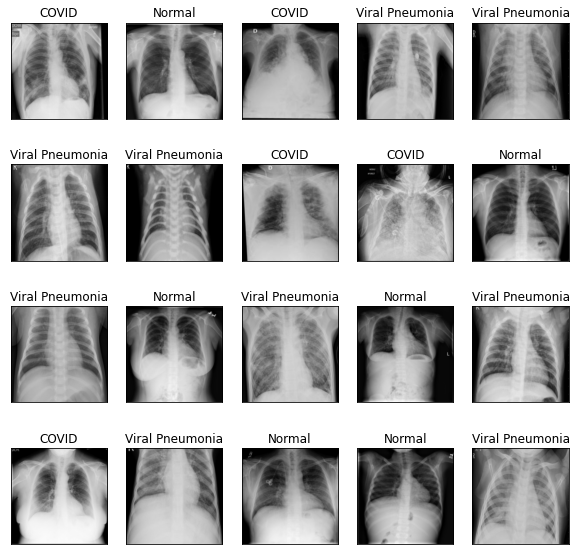

In [ ]:
# Visualize a few sample images from the dataset 

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

classes = ["COVID", "Normal", "Viral Pneumonia"]

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(10, 10))
for idx in np.arange(20):
    ax = fig.add_subplot(4, 20/4, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

#Testing Functions#

In [ ]:
# Compute the accuracy of the prediction compared to the labels 
def get_accuracy(model, data_loader): 
  correct = 0
  total = 0
  for imgs, labels in data_loader:
    
    #############################################
    #To Enable GPU Usage
    if use_cuda and torch.cuda.is_available():
      imgs = imgs.cuda()
      labels = labels.cuda()
    #############################################
    
    output = model(imgs)
    
    #select index with maximum prediction score
    pred = output.max(1, keepdim=True)[1]
    correct += pred.eq(labels.view_as(pred)).sum().item()
    total += imgs.shape[0]
  return correct / total

In [ ]:
# Compute the F1 score of the testing 
"""
As the main purpose of our project is to identify patients with COVID-19 
infection, we only define the COVID-19 class to be positive, where the 
viral pneumonia class is classified as negative along with the normal 
class. 
"""
def F1_score(model, data_loader): 
  true_pos = 0 
  true_neg = 0 
  false_pos = 0 
  false_neg = 0 
  
  for imgs, labels in data_loader: 
    
    #############################################
    #To Enable GPU Usage
    if use_cuda and torch.cuda.is_available():
      imgs = imgs.cuda()
      labels = labels.cuda()
    #############################################
    output = model(imgs)

    # Select index with maximum prediction score 
    pred = output.max(1, keepdim=True)[1].tolist()
    for i in range(len(pred)): 
      if labels[i] == 0: 
        if pred[i][0] == labels[i]: 
          true_pos += 1
        else: 
          false_neg += 1
      else: 
        if pred[i][0] == 0: 
          false_pos += 1
        else: 
          true_neg += 1
  print("True positive:", true_pos)
  print("False positive:", false_pos)
  print("False negative:", false_neg)
  print("True negative:", true_neg)
  print()
  recall = true_pos / (true_pos + false_neg)
  precision = true_pos / (true_pos + false_pos)
  print("Recall:", recall)
  print("Precision:", precision)
  print("F1 Score:", 2 * precision * recall / (precision + recall))

#Baseline Model#

Our baseline model is built based on a CNN model with convolutional and fully-connected layers only. 

In [ ]:
def train(model, train_loader, val_loader, batch_size=256, 
              learning_rate=0.05, num_epochs=20): 
  
  torch.manual_seed(1000)
  
  #################################################################
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=learning_rate)
  iters, losses, train_acc, val_acc = [], [], [], []
  ##############################################################
  # training 
  n = 0 

  for epoch in range(num_epochs):
    for imgs, labels in iter(train_loader): 
      #############################################
      #To Enable GPU Usage
      
      if use_cuda and torch.cuda.is_available():
        imgs = imgs.cuda()
        labels = labels.cuda()
      #############################################
      out = model(imgs)                       # forward pass 
      loss = criterion(out, labels)           # compute the total loss 
      loss.backward()
      optimizer.step()                        # backward pass (compute para. update) 
      optimizer.zero_grad()                   # a clean up step for PyTorch 
      
    ##############################################################
    # save the current training info. 
    iters.append(n)
    losses.append(float(loss)/batch_size)

    train_acc.append(get_accuracy(model, train_loader))

    val_acc.append(get_accuracy(model, val_loader))
    print("epoch number ", epoch+1, "training accuracy: ",train_acc[epoch] , " and validation accuracy: ",val_acc[epoch])
    n+=1
  
  # plotting 
  plt.title ('Training Curve')
  plt.plot(iters, losses, label='Train')
  plt.xlabel('Iterations')
  plt.ylabel('Loss')
  plt.show()

  plt.title("Training Curve")
  plt.plot(iters, train_acc, label='Train')
  plt.plot(iters, val_acc, label='Validation')
  plt.xlabel('Iterations')
  plt.ylabel('Training Accuracy')
  plt.legend(loc='best')
  plt.show() 
  
  print("Final Training Accuracy: {}".format(train_acc[-1]))
  print('Final Validation Accuracy: {}'.format(val_acc[-1]))


In [ ]:
class BASE(nn.Module): 
    def __init__(self):
        super(BASE, self).__init__()
        self.name = "BASE"
        self.conv1 = nn.Conv2d(3, 5, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 10, 5)
        self.conv3 = nn.Conv2d(10, 25, 5)
        self.fc1 = nn.Linear(24* 25* 24, 128)
        self.fc2 = nn.Linear(128, 32)
        self.fc3 = nn.Linear (32,3)

    def forward(self, x):                     # torch.Size([216, 3, 224, 224])
        x = self.pool(F.relu(self.conv1(x)))  #torch.Size([216, 5, 110, 110])
        x = self.pool(F.relu(self.conv2(x))) #torch.Size([216, 10, 53, 53])
        x = self.pool(F.relu(self.conv3(x)))
       
        x = x.view(-1, 24* 25* 24)             #torch.Size([216, 28090])
        x = F.relu(self.fc1(x))               #torch.Size([216, 32])
        x = F.relu(self.fc2(x)) 
        x = self.fc3(x)
        return x
 

CUDA is available!  Training on GPU ...


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


epoch number  1 training accuracy:  0.7538035961272476  and validation accuracy:  0.7551867219917012
epoch number  2 training accuracy:  0.7601045028430921  and validation accuracy:  0.7593360995850622
epoch number  3 training accuracy:  0.5683110496388505  and validation accuracy:  0.5597049331489166
epoch number  4 training accuracy:  0.7879207007837713  and validation accuracy:  0.7874596588289534
epoch number  5 training accuracy:  0.818195789150146  and validation accuracy:  0.8109727985246658
epoch number  6 training accuracy:  0.8540033809743354  and validation accuracy:  0.839096357768557
epoch number  7 training accuracy:  0.8599969263869679  and validation accuracy:  0.8335638543107423
epoch number  8 training accuracy:  0.8827416628246504  and validation accuracy:  0.8616874135546335
epoch number  9 training accuracy:  0.8922698632242201  and validation accuracy:  0.8662978331028124
epoch number  10 training accuracy:  0.8532349777163055  and validation accuracy:  0.83725218

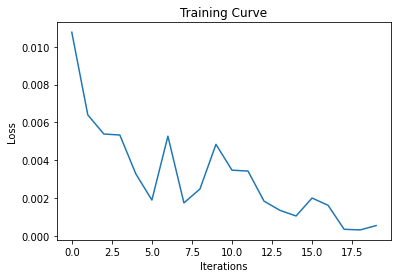

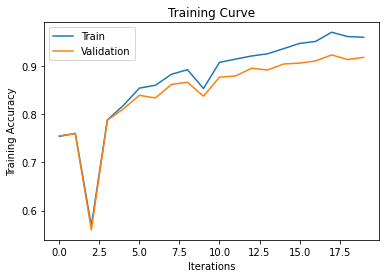

Final Training Accuracy: 0.9595819886276318
Final Validation Accuracy: 0.9179345320424158


In [ ]:
Baseline_model = BASE()
if use_cuda and torch.cuda.is_available():
    Baseline_model.cuda()
    print('CUDA is available!  Training on GPU ...')

train (Baseline_model, train_loader, val_loader, batch_size=64, learning_rate=0.001, num_epochs=20)

In [ ]:
print("Final test accuracy of the Baseline model is:", get_accuracy(Baseline_model, test_loader))

Final test accuracy of the Baseline model is: 0.9203132197144174


In [ ]:
F1_score(Baseline_model, test_loader)

True positive: 660
False positive: 58
False negative: 66
True negative: 1386

Recall: 0.9090909090909091
Precision: 0.9192200557103064
F1 Score: 0.9141274238227146


#Advanced Models#
Although our baseline model has already shown good performance in terms of accuracy, we have also tried out some of the more advanced models for image recognition to compare their performance with the baseline model. 

##AlexNet##



In [ ]:
# Use AlexNet 
alexnet = torchvision.models.alexnet(pretrained=True)

In [ ]:
# Directories used to store the pre-trained features 
feature_dir = '/content/drive/MyDrive/APS360/APS360 Project/AlexNet Features'  # Change the directory if necessary 
train_feature_dir = os.path.join(feature_dir, 'train/')
val_feature_dir = os.path.join(feature_dir, 'val/')
test_feature_dir = os.path.join(feature_dir, 'test/')

In [ ]:
train_alex_loader = torch.utils.data.DataLoader(dataset, batch_size=1,
                                      num_workers=num_workers, sampler=train_sampler)
val_alex_loader = torch.utils.data.DataLoader(dataset, batch_size=1,
                                      num_workers=num_workers, sampler=val_sampler)
test_alex_loader = torch.utils.data.DataLoader(dataset, batch_size=1,
                                      num_workers=num_workers, sampler=test_sampler)

In [ ]:
# Save the computed features for the training and validation set 
use_cuda = True 

n = 0 
for img, label in iter(train_alex_loader): 
  if use_cuda and torch.cuda.is_available():
    features = alexnet.features(img).cuda()
    features_tensor = torch.from_numpy(features.cpu().detach().numpy())
  else: 
    features = alexnet.features(img)
    features_tensor = torch.from_numpy(features.detach().numpy())
  
  folder_dir = train_feature_dir + str(classes[label])
  if not os.path.isdir(folder_dir):
    os.mkdir(folder_dir)
  torch.save(features_tensor.squeeze(0), folder_dir + '/' + str(n) + '.tensor')
  n += 1

n = 0 
for img, label in iter(val_alex_loader): 
  if use_cuda and torch.cuda.is_available():
    features = alexnet.features(img).cuda()
    features_tensor = torch.from_numpy(features.cpu().detach().numpy())
  else: 
    features = alexnet.features(img)
    features_tensor = torch.from_numpy(features.detach().numpy())
  
  folder_dir = val_feature_dir + str(classes[label])
  if not os.path.isdir(folder_dir):
    os.mkdir(folder_dir)
  torch.save(features_tensor.squeeze(0), folder_dir + '/' + str(n) + '.tensor')
  n += 1

In [ ]:
# Reload the pre-trained features 
train_features = torchvision.datasets.DatasetFolder(
    train_feature_dir, loader=torch.load, extensions=('.tensor'))
train_features_loader = torch.utils.data.DataLoader(train_features, batch_size=batch_size, shuffle=True) 
val_features = torchvision.datasets.DatasetFolder(
    val_feature_dir, loader=torch.load, extensions=('.tensor'))
val_features_loader = torch.utils.data.DataLoader(val_features, batch_size=batch_size, shuffle=True)  

In [ ]:
class AlexNet(nn.Module): 
  def __init__(self): 
    super(AlexNet, self).__init__()
    self.conv1 = nn.Conv2d(256, 512, 3)
    self.pool = nn.MaxPool2d(2, 2)
    self.fc1 = nn.Linear(2 * 2 * 512, 512)
    self.fc2 = nn.Linear(512, 9)

  def forward(self, x): 
    x = self.pool(F.relu(self.conv1(x)))
    x = x.view(-1, 2 * 2 * 512)
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    return x

CUDA is available!  Training on GPU ...
epoch number  1 training accuracy:  0.9168459883184753  and validation accuracy:  0.9100553505535055
epoch number  2 training accuracy:  0.9623424531201967  and validation accuracy:  0.9501845018450185
epoch number  3 training accuracy:  0.9608054103904089  and validation accuracy:  0.9428044280442804
epoch number  4 training accuracy:  0.9826314171533969  and validation accuracy:  0.9640221402214022
epoch number  5 training accuracy:  0.9901629265293576  and validation accuracy:  0.9617158671586716
epoch number  6 training accuracy:  0.9963110974485091  and validation accuracy:  0.9690959409594095
epoch number  7 training accuracy:  0.9992314786351061  and validation accuracy:  0.9704797047970479
epoch number  8 training accuracy:  0.9996925914540424  and validation accuracy:  0.9677121771217713
epoch number  9 training accuracy:  1.0  and validation accuracy:  0.9672509225092251
epoch number  10 training accuracy:  1.0  and validation accuracy:

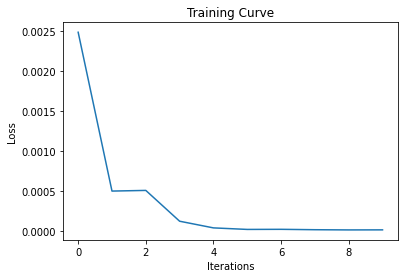

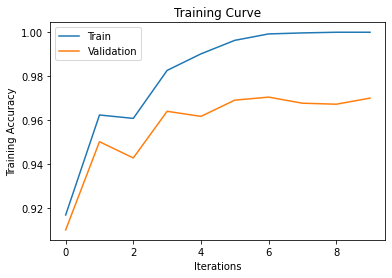

Final Training Accuracy: 1.0
Final Validation Accuracy: 0.9700184501845018


In [ ]:
# Train the AlexNet by tuning hyperparameters 
alex_model = AlexNet() 
if use_cuda and torch.cuda.is_available():
  alex_model.cuda()
  print('CUDA is available!  Training on GPU ...')

train(alex_model, train_features_loader, val_features_loader, 
      batch_size=batch_size, learning_rate=0.001, num_epochs=10)

In [ ]:
# Compute features for the testing set 
n = 0 
for img, label in iter(test_alex_loader): 
  if use_cuda and torch.cuda.is_available():
    features = alexnet.features(img).cuda()
    features_tensor = torch.from_numpy(features.cpu().detach().numpy())
  else: 
    features = alexnet.features(img)
    features_tensor = torch.from_numpy(features.detach().numpy())
  
  folder_dir = test_feature_dir + str(classes[label])
  if not os.path.isdir(folder_dir):
    os.mkdir(folder_dir)
  torch.save(features_tensor.squeeze(0), folder_dir + '/' + str(n) + '.tensor')
  n += 1

In [ ]:
# Reload the testing features 
test_features = torchvision.datasets.DatasetFolder(
    test_feature_dir, loader=torch.load, extensions=('.tensor'))
test_features_loader = torch.utils.data.DataLoader(test_features, batch_size=batch_size, shuffle=True)

In [ ]:
print("Final test accuracy of the AlexNet model is:", get_accuracy(alex_model, test_features_loader))

Final test accuracy of the AlexNet model is: 0.9728110599078341


In [ ]:
F1_score(alex_model, test_features_loader)

True positive: 710
False positive: 30
False negative: 16
True negative: 1414

Recall: 0.977961432506887
Precision: 0.9594594594594594
F1 Score: 0.9686221009549795


##GoogLeNet (Inception)##

In [ ]:
# Locating the dataset in the drive 
orig_data_dir = '/content/drive/MyDrive/APS360/APS360 Project/Data'  # Change the directory of the dataset if necessary 
# Resize and crop images into size 224 x 224
transforms = transforms.Compose([
    transforms.Resize(299),
    transforms.CenterCrop(299),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [ ]:
# After balancing the dataset, here are the counts of the number of images we have 
normal_dir = orig_data_dir + "/Normal"
total_files = 0 
for base, dirs, files in os.walk(normal_dir): 
  for Files in files: 
    total_files += 1
print("There are", total_files, "images for the normal set")

covid_dir = orig_data_dir + "/COVID"
total_files = 0 
for base, dirs, files in os.walk(covid_dir): 
  for Files in files: 
    total_files += 1
print("There are", total_files, "images for the COVID set")

viral_dir = orig_data_dir + "/Viral Pneumonia"
total_files = 0 
for base, dirs, files in os.walk(viral_dir): 
  for Files in files: 
    total_files += 1
print("There are", total_files, "images for the viral pneumonia set")

There are 3615 images for the normal set
There are 3615 images for the COVID set
There are 3615 images for the viral pneumonia set


In [ ]:
# Dataloader preperation
batch_size = 64
num_workers = 1
dataset = datasets.ImageFolder(orig_data_dir, transform=transforms)

data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                      num_workers=num_workers, shuffle=True)

In [ ]:
# Randomly separate the dataset into training, validation, and test set 
indices = np.arange(len(dataset))

# Split into train, validation and test dataset
np.random.seed(1000) # Fixed numpy random seed for reproducible shuffling
np.random.shuffle(indices)
train_data = int(len(indices) * 0.2) #split at 60% for training set
valid_data = int(len(indices) * 0.0666666) #split at 20% for validation set
test_data = int(len(indices) * 0.0666666) #split at 20% for test set


In [ ]:
# Convert the three sets of data to data loader for training 

# split train val and test by index
train_indics, val_indices, test_indices = indices[:train_data], indices[train_data:valid_data + train_data], indices[valid_data+train_data:] 

G_train_sampler = SubsetRandomSampler(train_indics)
G_train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                      num_workers=num_workers, sampler=G_train_sampler)
G_val_sampler = SubsetRandomSampler(val_indices)
G_val_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                      num_workers=num_workers, sampler=G_val_sampler)
G_test_sampler = SubsetRandomSampler(test_indices)
G_test_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                      num_workers=num_workers, sampler=G_test_sampler)

In [ ]:
G_model = models.googlenet(pretrained=True)

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth


CUDA is available!  Training on GPU ...


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


epoch number  1 training accuracy:  0.970954356846473  and validation accuracy:  0.9445983379501385
epoch number  2 training accuracy:  0.9852466574458276  and validation accuracy:  0.9681440443213296
epoch number  3 training accuracy:  0.9926233287229138  and validation accuracy:  0.9792243767313019
epoch number  4 training accuracy:  0.9949285384970032  and validation accuracy:  0.981994459833795
epoch number  5 training accuracy:  0.9972337482710927  and validation accuracy:  0.9792243767313019


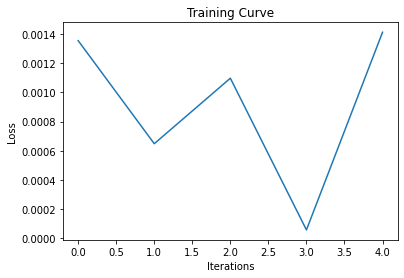

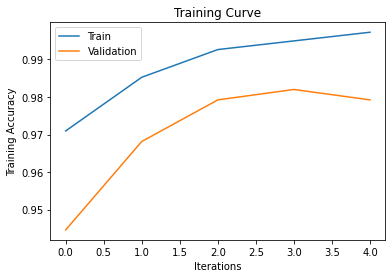

Final Training Accuracy: 0.9972337482710927
Final Validation Accuracy: 0.9792243767313019


In [ ]:
if use_cuda and torch.cuda.is_available():
  G_model.cuda()
  print('CUDA is available!  Training on GPU ...')
 
train(G_model, G_train_loader, G_val_loader, batch_size=batch_size, learning_rate=0.001, num_epochs=5)

In [ ]:
print("Final test accuracy of the GoogleNet model is:", get_accuracy(G_model, G_test_loader))

Final test accuracy of the GoogleNet model is: 0.9730952979632889


In [ ]:
F1_score(G_model, G_test_loader)

True positive: 2550
False positive: 88
False negative: 97
True negative: 5219

Recall: 0.9633547412164715
Precision: 0.9666413949962093
F1 Score: 0.9649952696310312


##Visual Geometry Group (VGG)##

In [ ]:
# Locating the dataset in the drive 
orig_data_dir = '/content/drive/MyDrive/APS360/APS360 Project/Data'  # Change the directory of the dataset if necessary 

In [ ]:
# Resize and crop images into size 224 x 224
transforms = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [ ]:
# After balancing the dataset, here are the counts of the number of images we have 
normal_dir = orig_data_dir + "/Normal"
total_files = 0 
for base, dirs, files in os.walk(normal_dir): 
  for Files in files: 
    total_files += 1
print("There are", total_files, "images for the normal set")

covid_dir = orig_data_dir + "/COVID"
total_files = 0 
for base, dirs, files in os.walk(covid_dir): 
  for Files in files: 
    total_files += 1
print("There are", total_files, "images for the COVID set")

viral_dir = orig_data_dir + "/Viral Pneumonia"
total_files = 0 
for base, dirs, files in os.walk(viral_dir): 
  for Files in files: 
    total_files += 1
print("There are", total_files, "images for the viral pneumonia set")

There are 3615 images for the normal set
There are 3615 images for the COVID set
There are 3615 images for the viral pneumonia set


In [ ]:
# Dataloader preperation
batch_size = 32
num_workers = 1
dataset = datasets.ImageFolder(orig_data_dir, transform=transforms)

data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                      num_workers=num_workers, shuffle=True)

In [ ]:
# Randomly separate the dataset into training, validation, and test set 
indices = np.arange(len(dataset))

# Split into train, validation and test dataset
np.random.seed(1000) # Fixed numpy random seed for reproducible shuffling
np.random.shuffle(indices)
train_data = int(len(indices) * 0.2) #split at 20% for training set
valid_data = int(len(indices) * 0.066666) #split at 20% for validation set
test_data = int(len(indices) * 0.066666) #split at 20% for test set

In [ ]:
# Convert the three sets of data to data loader for training 

# split train val and test by index
train_indics, val_indices, test_indices = indices[:train_data], indices[train_data:valid_data + train_data], indices[valid_data+train_data:] 

vgg_train_sampler = SubsetRandomSampler(train_indics)
vgg_train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                      num_workers=num_workers, sampler=vgg_train_sampler)
vgg_val_sampler = SubsetRandomSampler(val_indices)
vgg_val_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                      num_workers=num_workers, sampler=vgg_val_sampler)
vgg_test_sampler = SubsetRandomSampler(test_indices)
vgg_test_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                      num_workers=num_workers, sampler=vgg_test_sampler)

In [ ]:
vgg_model = models.vgg16(pretrained=True)

CUDA is available!  Training on GPU ...


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


epoch number  1 training accuracy:  0.8400184416781927  and validation accuracy:  0.8254847645429363
epoch number  2 training accuracy:  0.9013370216689719  and validation accuracy:  0.8725761772853186
epoch number  3 training accuracy:  0.8727524204702628  and validation accuracy:  0.853185595567867
epoch number  4 training accuracy:  0.929921622867681  and validation accuracy:  0.889196675900277
epoch number  5 training accuracy:  0.9363762102351314  and validation accuracy:  0.8961218836565097


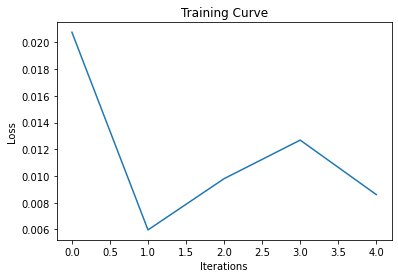

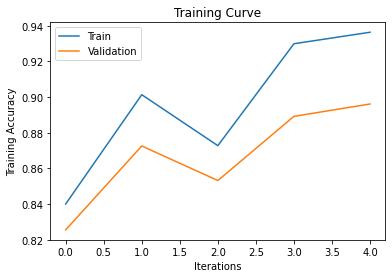

Final Training Accuracy: 0.9363762102351314
Final Validation Accuracy: 0.8961218836565097


In [ ]:
if use_cuda and torch.cuda.is_available():
  vgg_model.cuda()
  print('CUDA is available!  Training on GPU ...')
 
train(vgg_model, vgg_train_loader, vgg_val_loader, batch_size=batch_size, learning_rate=0.001, num_epochs=5)
# train(vgg16, vgg_trainloader, vgg_valoader, batch_size=batch_size, learning_rate=0.001, num_epochs=5)

In [ ]:
print("Final test accuracy of the VGG model is:", get_accuracy(vgg_model, vgg_test_loader))

Final test accuracy of the VGG model is: 0.9063364344983657


In [ ]:
F1_score(vgg_model, vgg_test_loader)

True positive: 2357
False positive: 278
False negative: 290
True negative: 5029

Recall: 0.8904420098224405
Precision: 0.8944971537001898
F1 Score: 0.8924649753881105


##ResNet##

In [ ]:
resnet_model = models.resnet.resnet18(pretrained=True)
num_ftrs = resnet_model.fc.in_features
resnet_model.fc = nn.Linear(num_ftrs, 3)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet_model = resnet_model.to(device)

CUDA is available!  Training on GPU ...


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


epoch number  1 training accuracy:  0.9764868603042877  and validation accuracy:  0.954817888427847
epoch number  2 training accuracy:  0.9895497156907945  and validation accuracy:  0.970954356846473
epoch number  3 training accuracy:  0.9907791609036423  and validation accuracy:  0.966804979253112
epoch number  4 training accuracy:  0.9912402028584602  and validation accuracy:  0.9727985246657446
epoch number  5 training accuracy:  0.9966190256646689  and validation accuracy:  0.979253112033195


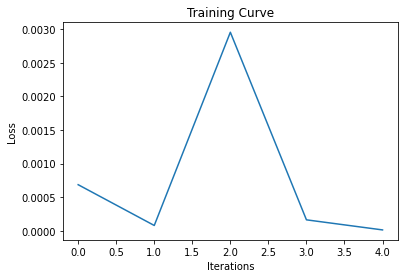

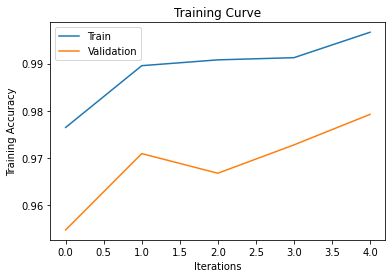

Final Training Accuracy: 0.9966190256646689
Final Validation Accuracy: 0.979253112033195


In [ ]:
# Train the ResNet by tuning hyperparameters 
if use_cuda and torch.cuda.is_available():
  print('CUDA is available!  Training on GPU ...')

train(resnet_model, train_loader, val_loader, batch_size=batch_size, learning_rate=0.001, num_epochs=5)

In [ ]:
print("Final test accuracy of the ResNet model is:", get_accuracy(resnet_model, test_loader))

Final test accuracy of the ResNet model is: 0.9723374827109267


In [ ]:
F1_score(resnet_model, test_loader)

True positive: 709
False positive: 20
False negative: 17
True negative: 1423

Recall: 0.9765840220385675
Precision: 0.9725651577503429
F1 Score: 0.9745704467353952


##Reference Model##
Source: https://www.kaggle.com/hraouak/covid-radiography-acc-99

We have replicated an online model with high accuracy to compare with our built models. 

In [ ]:
# Define the network of the model 
class conv_layer(nn.Module):

    def __init__(self, in_features, out_features):
        super(conv_layer, self).__init__()
        self.conv = nn.Conv2d(in_features, out_features, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.norm = nn.BatchNorm2d(out_features)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)


    def forward(self, X: torch.Tensor) -> torch.Tensor:
        X = self.conv(X)
        X = self.relu(X)
        X = self.norm(X)
        X = self.pool(X)
        return X


class ref_Network(nn.Module):

    def __init__(self):
        super(ref_Network, self).__init__()
        self.input_norm = nn.BatchNorm2d(3, affine=False)
        self.layer1 = conv_layer(in_features=3, out_features=8)
        self.layer2 = conv_layer(in_features=8, out_features=16)
        self.layer3 = conv_layer(in_features=16, out_features=32)
        self.layer4 = conv_layer(in_features=32, out_features=64)
        self.layer5 = conv_layer(in_features=64, out_features=128)
        self.layer6 = conv_layer(in_features=128, out_features=256)
        
        

        self.net = nn.Sequential(self.layer1, self.layer2, self.layer3, 
                                       self.layer4, self.layer5, self.layer6)
            
        
        self.fc1 = nn.Linear(in_features=2304, out_features=128)
        self.bn1 = nn.BatchNorm1d(128)
        
        self.fc2 = nn.Linear(in_features=128, out_features=32)
        self.bn2 = nn.BatchNorm1d(32)

        self.fc3 = nn.Linear(in_features=32, out_features=8)
        self.bn3 = nn.BatchNorm1d(8)

        self.fc4 = nn.Linear(in_features=8, out_features=3)

        self.lin = nn.Sequential(self.fc1, self.bn1, self.fc2, self.bn2,
                                       self.fc3, self.bn3, self.fc4)  


    def forward(self, X: torch.Tensor) -> torch.Tensor:
        X = self.input_norm(X)
        X = self.net(X)
        X = X.reshape(X.size(0), -1)
        X = self.lin(X)
        X = F.elu(X, alpha=1.0, inplace=False)
        return X

CUDA is available!  Training on GPU ...
epoch number  1 training accuracy:  0.9545035351982785  and validation accuracy:  0.9418819188191881
epoch number  2 training accuracy:  0.9798647402397787  and validation accuracy:  0.9571033210332104
epoch number  3 training accuracy:  0.9933907162619121  and validation accuracy:  0.9681734317343174
epoch number  4 training accuracy:  0.998616661543191  and validation accuracy:  0.9737084870848709
epoch number  5 training accuracy:  0.9989240700891485  and validation accuracy:  0.9704797047970479
epoch number  6 training accuracy:  0.9998462957270212  and validation accuracy:  0.9806273062730627
epoch number  7 training accuracy:  1.0  and validation accuracy:  0.9810885608856088
epoch number  8 training accuracy:  1.0  and validation accuracy:  0.981549815498155
epoch number  9 training accuracy:  0.9995388871810637  and validation accuracy:  0.9773985239852399
epoch number  10 training accuracy:  0.9993851829080849  and validation accuracy:  

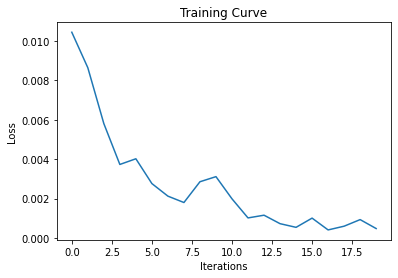

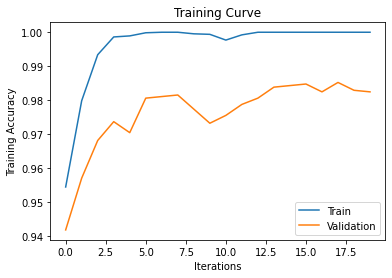

Final Training Accuracy: 1.0
Final Validation Accuracy: 0.9824723247232472


In [ ]:
# Tuning

ref_model = ref_Network()

if use_cuda and torch.cuda.is_available():
    ref_model.cuda()
    print('CUDA is available!  Training on GPU ...')

train(ref_model,train_loader,val_loader,batch_size=batch_size,
           learning_rate=0.001,num_epochs=20)

In [ ]:
print("Final test accuracy of the reference model is:", get_accuracy(ref_model, test_loader))

Final test accuracy of the Covid_Net model is: 0.9797235023041475


In [ ]:
F1_score(ref_model, test_loader)

True positive: 713
False positive: 21
False negative: 13
True negative: 1423

Recall: 0.9820936639118457
Precision: 0.9713896457765667
F1 Score: 0.9767123287671232


##Demonstration##
To demonstrate all models built in this project, we have three CXR images (one from each class) that have never been tested/used in the training process before. 

In this section, we pass in the three images into all built models and visualize the prediction from the models on these three images. 

In [ ]:
demon_dir = '/content/drive/MyDrive/APS360/APS360 Project/Demonstration' 
dataset = datasets.ImageFolder(demon_dir, transform=im_transforms)
demon_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  after removing the cwd from sys.path.


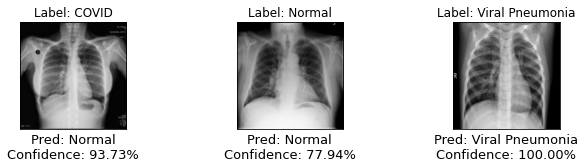

In [ ]:
# Demonstrate the Baseline model 
pred = [] 
for image, label in demon_loader: 
  pred.append(F.softmax(Baseline_model(image.cuda())).tolist())

# obtain one batch of training images
dataiter = iter(demon_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

classes = ["COVID", "Normal", "Viral Pneumonia"]

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(11, 9))
for idx in range(len(images)):
    ax = fig.add_subplot(4, 20/6.5, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title("Label: " + classes[labels[idx]])
    ax.set_xlabel("Pred: " + classes[pred[0][idx].index(max(pred[0][idx]))] 
                  + "\nConfidence: %2.2f" % (max(pred[0][idx]) * 100) + "%", fontsize=13)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


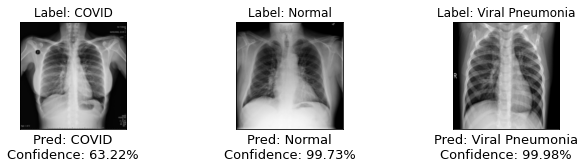

In [ ]:
# Demonstrate the primary AlexNet model 
alex_demon_dir = '/content/drive/MyDrive/APS360/APS360 Project/AlexNet Demon Features/'
alex_demon_loader = torch.utils.data.DataLoader(dataset, batch_size=1)

# Compute features for the demonstration images 
n = 0 
for img, label in iter(alex_demon_loader): 
  if use_cuda and torch.cuda.is_available():
    features = alexnet.features(img).cuda()
    features_tensor = torch.from_numpy(features.cpu().detach().numpy())
  else: 
    features = alexnet.features(img)
    features_tensor = torch.from_numpy(features.detach().numpy())
  
  folder_dir = alex_demon_dir + str(classes[label])
  if not os.path.isdir(folder_dir):
    os.mkdir(folder_dir)
  torch.save(features_tensor.squeeze(0), folder_dir + '/' + str(n) + '.tensor')
  n += 1

# Reload the computed features 
alex_demon_features = torchvision.datasets.DatasetFolder(
    alex_demon_dir, loader=torch.load, extensions=('.tensor'))
alex_demon_features_loader = torch.utils.data.DataLoader(alex_demon_features, 
                                                         batch_size=batch_size)

pred = [] 
for image, label in alex_demon_features_loader: 
  pred.append(F.softmax(alex_model(image.cuda())).tolist())

# obtain one batch of training images
dataiter = iter(demon_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

classes = ["COVID", "Normal", "Viral Pneumonia"]

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(11, 9))
for idx in range(len(images)):
    ax = fig.add_subplot(4, 20/6.5, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title("Label: " + classes[labels[idx]])
    ax.set_xlabel("Pred: " + classes[pred[0][idx].index(max(pred[0][idx]))] 
                  + "\nConfidence: %2.2f" % (max(pred[0][idx]) * 100) + "%", fontsize=13)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  after removing the cwd from sys.path.


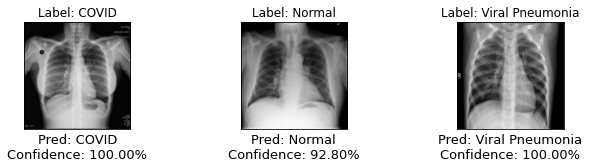

In [ ]:
# Demonstrate the GoogLeNet model 
pred = [] 
for image, label in demon_loader: 
  pred.append(F.softmax(G_model(image.cuda())).tolist())

# obtain one batch of training images
dataiter = iter(demon_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

classes = ["COVID", "Normal", "Viral Pneumonia"]

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(11, 9))
for idx in range(len(images)):
    ax = fig.add_subplot(4, 20/6.5, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title("Label: " + classes[labels[idx]])
    ax.set_xlabel("Pred: " + classes[pred[0][idx].index(max(pred[0][idx]))] 
                  + "\nConfidence: %2.2f" % (max(pred[0][idx]) * 100) + "%", fontsize=13)

In [ ]:
# Demonstrate the VGG model 
pred = [] 
for image, label in demon_loader: 
  pred.append(F.softmax(vgg16(image.cuda())).tolist())

# obtain one batch of training images
dataiter = iter(demon_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

classes = ["COVID", "Normal", "Viral Pneumonia"]

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(11, 9))
for idx in range(len(images)):
    ax = fig.add_subplot(4, 20/6.5, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title("Label: " + classes[labels[idx]])
    ax.set_xlabel("Pred: " + classes[pred[0][idx].index(max(pred[0][idx]))] 
                  + "\nConfidence: %2.2f" % (max(pred[0][idx]) * 100) + "%", fontsize=13)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  after removing the cwd from sys.path.


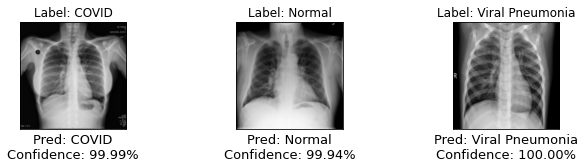

In [ ]:
# Demonstrate the ResNet model 
pred = [] 
for image, label in demon_loader: 
  pred.append(F.softmax(resnet_model(image.cuda())).tolist())

# obtain one batch of training images
dataiter = iter(demon_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

classes = ["COVID", "Normal", "Viral Pneumonia"]

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(11, 9))
for idx in range(len(images)):
    ax = fig.add_subplot(4, 20/6.5, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title("Label: " + classes[labels[idx]])
    ax.set_xlabel("Pred: " + classes[pred[0][idx].index(max(pred[0][idx]))] 
                  + "\nConfidence: %2.2f" % (max(pred[0][idx]) * 100) + "%", fontsize=13)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  after removing the cwd from sys.path.


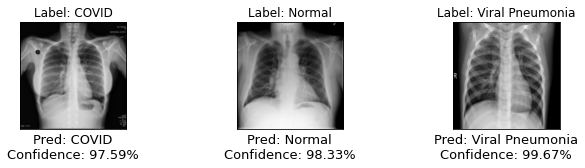

In [ ]:
# Demonstrate the Reference model 
pred = [] 
for image, label in demon_loader: 
  pred.append(F.softmax(ref_model(image.cuda())).tolist())

# obtain one batch of training images
dataiter = iter(demon_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

classes = ["COVID", "Normal", "Viral Pneumonia"]

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(11, 9))
for idx in range(len(images)):
    ax = fig.add_subplot(4, 20/6.5, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title("Label: " + classes[labels[idx]])
    ax.set_xlabel("Pred: " + classes[pred[0][idx].index(max(pred[0][idx]))] 
                  + "\nConfidence: %2.2f" % (max(pred[0][idx]) * 100) + "%", fontsize=13)